# Acea Smart Water Analytics 

A water supply company struggles with the need to forecast the water level in a waterbody (water spring, lake, river, or aquifer) to handle daily consumption. During fall and winter waterbodies are refilled, but during spring and summer they start to drain. To help preserve the health of these waterbodies it is important to predict the most efficient water availability, in terms of level and water flow for each day of the year.

The point of the competition is to predict the amount of water in each unique waterbody. The challenge is to determine how features influence the water availability of each presented waterbody. Models should capture volumes for each waterbody (for a model working on a monthly interval a forecast over the month is expected).

The desired outcome is a notebook that can generate four mathematical models, one for each category of waterbody (acquifers, water springs, river, lake) that might be applicable to each single waterbody.

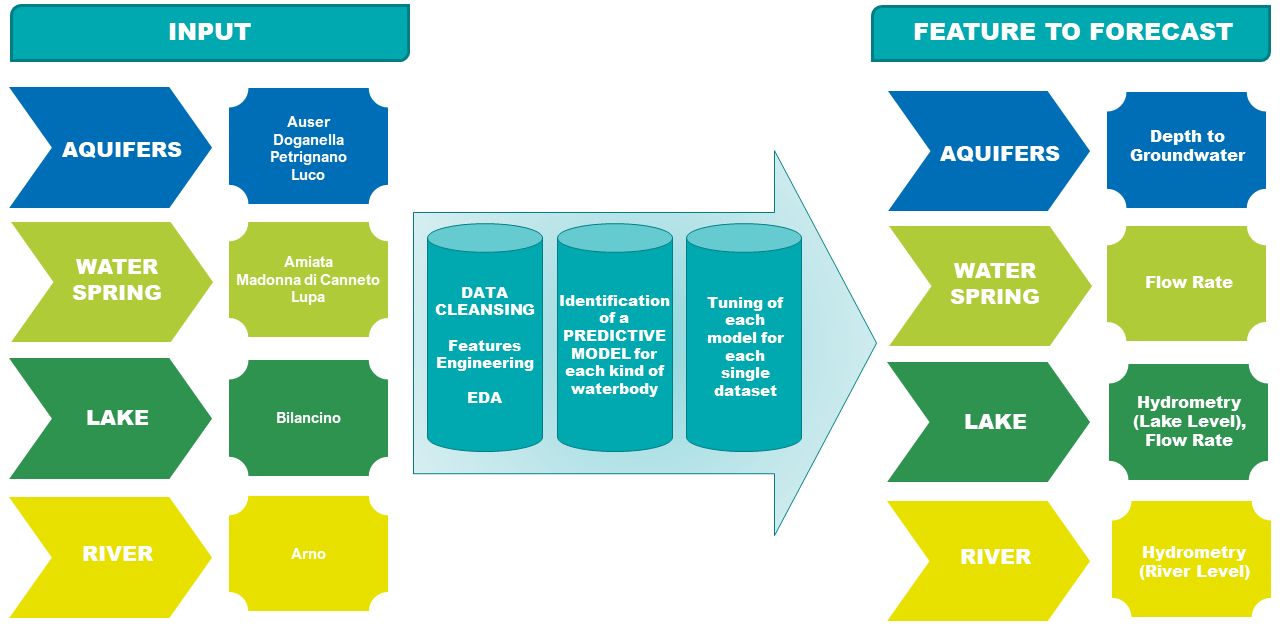


# Evaluation 
This is an Analytics competition where your task is to create a Notebook that best addresses the Evaluation criteria below. Submissions should be shared directly with host and will be judged by the Acea Group based on how well they address:

**Methodology/Completeness (min 0 points, max 5 points)**

- Are the statistical models appropriate given the data?
- Did the author develop one or more machine learning models?
- Did the author provide a way of assessing the performance and accuracy of their solution?
- What is the Mean Absolute Error (MAE) of the models?
- What is the Root Mean Square Error (RMSE) of the models?

**Presentation (min 0 points, max 5 points)**

- Does the notebook have a compelling and coherent narrative?
- Does the notebook contain data visualizations that help to communicate the author’s main points?
- Did the author include a thorough discussion on the intersection between features and their prediction? For example between rainfall and amount/level of water.
- Was there discussion of automated insight generation, demonstrating what factors to take into account?
- Is the code documented in a way that makes it easy to understand and reproduce?
- Were all external sources of data made public and cited appropriately?

**Application (min 0 points, max 5 points)**

- Is the provided model useful/able to forecast water availability in terms of level or water flow in a time interval of the year?
- Is the provided methodology applicable also on new datasets belong to another waterbody?


## Deadline
- Entry and Final submission deadline: **February 17, 2021**
- Winners announced: **March 10, 2021**

# Loading and a first look at the data

This competition uses nine different datasets, completely independent and not linked to each other. Each dataset can represent a different kind of waterbody. As each waterbody is different from the other, the related features as well are different from each other. 

Let's see the shapes of datasets.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

from termcolor import colored

dfs = dict()

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            name = filename[:-4]
            dfs[name] = pd.read_csv(os.path.join(dirname, filename))

print("Names of objects and shape of datasets:")
for key in dfs:
    print(f"{key}, {dfs[key].shape}")


Names of objects and shape of datasets:
Aquifer_Doganella, (6026, 22)
Aquifer_Auser, (8154, 27)
Water_Spring_Amiata, (7487, 16)
Lake_Bilancino, (6603, 9)
Water_Spring_Madonna_di_Canneto, (3113, 4)
Aquifer_Luco, (7487, 22)
Aquifer_Petrignano, (5223, 8)
Water_Spring_Lupa, (4199, 3)
River_Arno, (8217, 17)


Drop the duplicates:

In [2]:
for key in dfs:
    dfs[key].drop_duplicates(inplace=True)

## Time data

All dataframes contain a column with the date of observation. Let's find time characteristics of datasets:
- first and last dates
- observations duration
- number of missing days

In [3]:
def type_helper(water_object_name:str):
    types = ("Aquifer", "Water_Spring", "Lake", "River")
    for _ in types:
        if water_object_name.startswith(_):
            return _

for key in dfs:
    dfs[key]['Date'] = pd.to_datetime(dfs[key]['Date'])

dfs_info = pd.DataFrame(dfs.keys(), columns=['name'])      
dfs_info['waterbody_type'] = dfs_info['name'].apply(type_helper)
dfs_info['first_date'] = [dfs[key]['Date'].min() for key in dfs]
dfs_info['last_date'] = [dfs[key]['Date'].max() for key in dfs]
dfs_info['duration'] = (dfs_info['last_date'] - dfs_info['first_date']).apply(lambda x: x.days)
dfs_info['unique_days'] = [dfs[key]['Date'].nunique() for key in dfs]
dfs_info['missing_days'] = dfs_info['duration']-dfs_info['unique_days']
dfs_info

,name,waterbody_type,first_date,last_date,duration,unique_days,missing_days
0,Aquifer_Doganella,Aquifer,2004-01-01,2020-12-06,6184,6026,158
1,Aquifer_Auser,Aquifer,1998-01-04,2020-12-06,8372,8154,218
2,Water_Spring_Amiata,Water_Spring,2000-01-01,2020-12-06,7645,7487,158
3,Lake_Bilancino,Lake,2002-01-07,2020-12-06,6908,6603,305
4,Water_Spring_Madonna_di_Canneto,Water_Spring,2012-01-01,2020-12-06,3262,3104,158
5,Aquifer_Luco,Aquifer,2000-01-01,2020-12-06,7645,7487,158
6,Aquifer_Petrignano,Aquifer,2006-01-04,2020-12-06,5450,5223,227
7,Water_Spring_Lupa,Water_Spring,2009-01-01,2020-12-06,4357,4199,158
8,River_Arno,River,1998-01-01,2020-12-06,8375,8217,158


An important reason for the differences in datasets is the different nature of the water reservoirs. Let's take a closer look at their differences.

# Aquifer Doganella

**Glossary**: [an aquifer](https://en.wikipedia.org/wiki/Aquifer) is an underground layer of water-bearing permeable rock, rock fractures or unconsolidated materials (gravel, sand, or silt). Groundwater can be extracted using a water well.

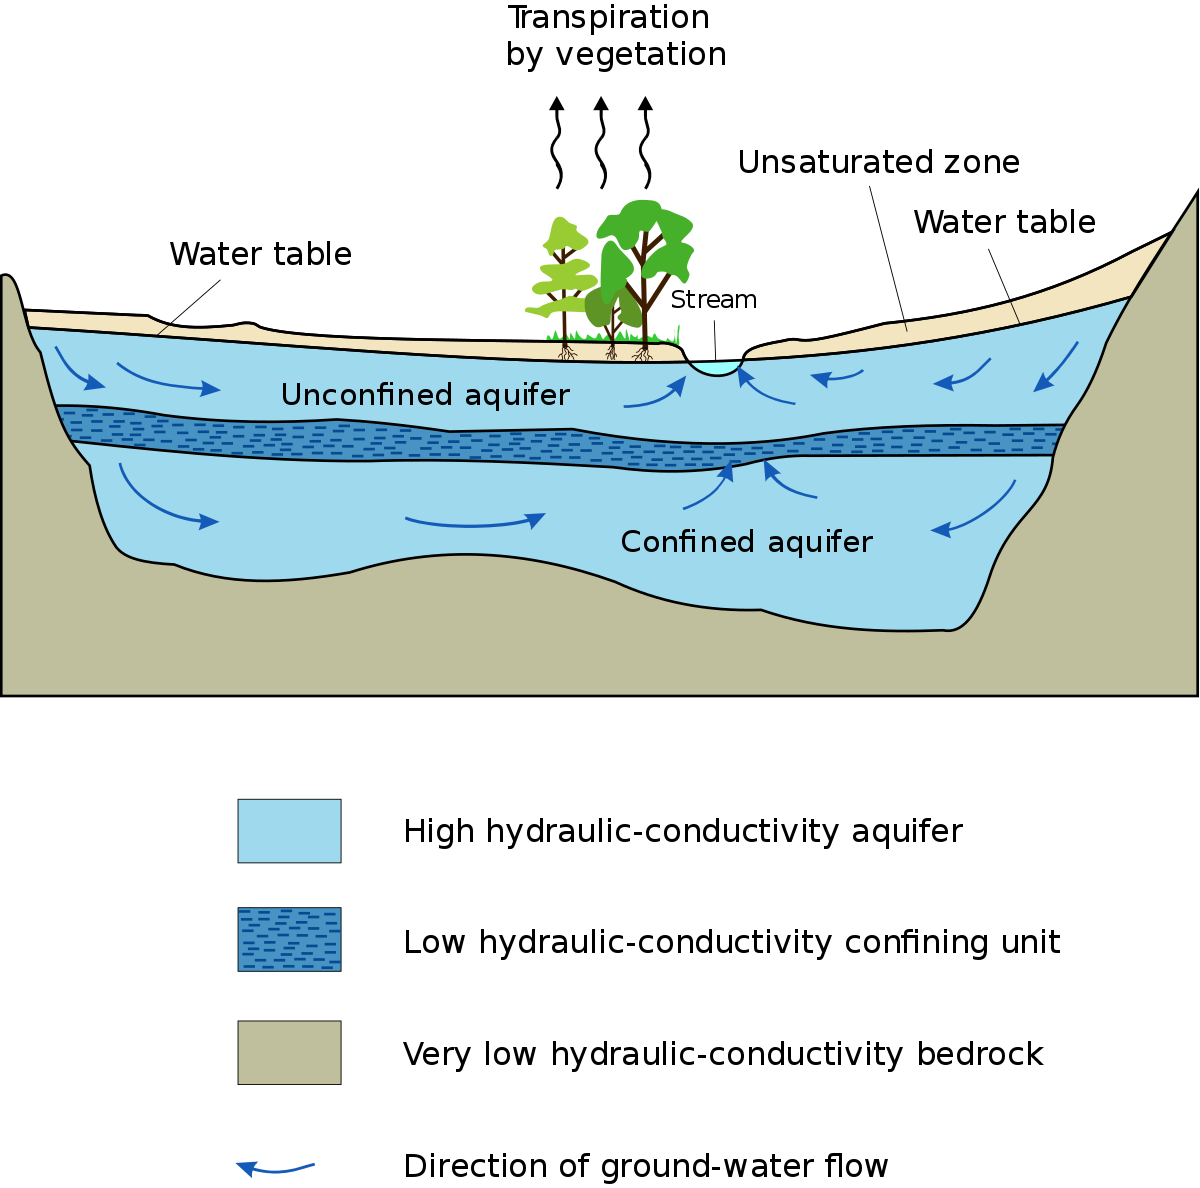
An example of an aquifer

The wells field Doganella is fed by two underground aquifers not fed by rivers or lakes but fed by meteoric infiltration. The upper aquifer is a water table with a thickness of about 30m. The lower aquifer is a semi-confined artesian aquifer with a thickness of 50m and is located inside lavas and tufa products. These aquifers are accessed through nine wells (in dataset there are columns names with postfix `_Pozzo[1-9]`). 

Approximately 80% of the drainage volumes come from the artesian aquifer. The aquifer levels are influenced by the following parameters: rainfall, humidity, subsoil, temperatures and drainage volumes.

**Type**: `Aquifer`

**Columns to predict**:
- `Depth_to_Groundwater_Pozzo_[1-9]`

In [4]:
dfs['Aquifer_Doganella'].head()

,Date,Rainfall_Monteporzio,Rainfall_Velletri,Depth_to_Groundwater_Pozzo_1,Depth_to_Groundwater_Pozzo_2,Depth_to_Groundwater_Pozzo_3,Depth_to_Groundwater_Pozzo_4,Depth_to_Groundwater_Pozzo_5,Depth_to_Groundwater_Pozzo_6,Depth_to_Groundwater_Pozzo_7,Depth_to_Groundwater_Pozzo_8,Depth_to_Groundwater_Pozzo_9,Volume_Pozzo_1,Volume_Pozzo_2,Volume_Pozzo_3,Volume_Pozzo_4,Volume_Pozzo_5+6,Volume_Pozzo_7,Volume_Pozzo_8,Volume_Pozzo_9,Temperature_Monteporzio,Temperature_Velletri
0,2004-01-01,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5.30,8.60
1,2004-02-01,0.20,0.80,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.70,6.25
2,2004-03-01,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5.40,9.80
3,2004-04-01,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.35,5.95
4,2004-05-01,0.20,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.60,5.85


In [5]:
dfs['Aquifer_Doganella'].describe()

,Rainfall_Monteporzio,Rainfall_Velletri,Depth_to_Groundwater_Pozzo_1,Depth_to_Groundwater_Pozzo_2,Depth_to_Groundwater_Pozzo_3,Depth_to_Groundwater_Pozzo_4,Depth_to_Groundwater_Pozzo_5,Depth_to_Groundwater_Pozzo_6,Depth_to_Groundwater_Pozzo_7,Depth_to_Groundwater_Pozzo_8,Depth_to_Groundwater_Pozzo_9,Volume_Pozzo_1,Volume_Pozzo_2,Volume_Pozzo_3,Volume_Pozzo_4,Volume_Pozzo_5+6,Volume_Pozzo_7,Volume_Pozzo_8,Volume_Pozzo_9,Temperature_Monteporzio,Temperature_Velletri
count,5399.00,5374.00,2537.00,2736.00,2774.00,2374.00,2508.00,2428.00,2311.00,2551.00,2339.00,1356.00,1360.00,1360.00,1360.00,1360.00,1360.00,1360.00,1360.00,4564.00,4383.00
mean,2.89,3.16,-36.93,-94.75,-111.64,-98.22,-102.55,-91.67,-95.82,-95.85,-94.71,1529.38,3433.49,3208.11,3527.63,7178.56,2491.40,3660.48,3239.81,13.46,15.57
std,8.62,8.91,10.18,3.89,3.81,2.39,3.71,2.22,1.69,2.52,3.78,1154.95,772.56,1084.94,700.01,1607.94,671.38,813.01,730.31,6.76,6.35
min,0.00,0.00,-59.50,-112.50,-117.80,-108.66,-109.89,-99.48,-97.43,-107.50,-105.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.62,-0.27
25%,0.00,0.00,-45.25,-98.46,-115.08,-100.50,-104.45,-92.95,-97.35,-97.84,-95.56,484.70,3521.22,2730.86,3596.37,7272.56,2282.24,3795.56,3110.93,8.09,10.36
50%,0.00,0.00,-34.90,-93.28,-111.81,-97.97,-101.81,-91.50,-96.57,-95.32,-94.27,1408.86,3591.81,3215.88,3667.21,7854.75,2677.16,3894.38,3378.45,13.05,15.15
75%,0.60,0.60,-28.51,-91.29,-108.03,-96.05,-99.87,-90.03,-94.02,-93.59,-92.36,2546.99,3845.60,3734.50,3864.40,7999.13,2917.10,3988.80,3466.80,18.99,20.73
max,112.60,106.60,-20.31,-89.67,-100.59,-94.00,-96.22,-88.60,-91.64,-92.47,-87.96,4171.28,4030.27,5378.80,4076.10,8360.21,3427.42,4341.71,4336.78,30.40,31.90


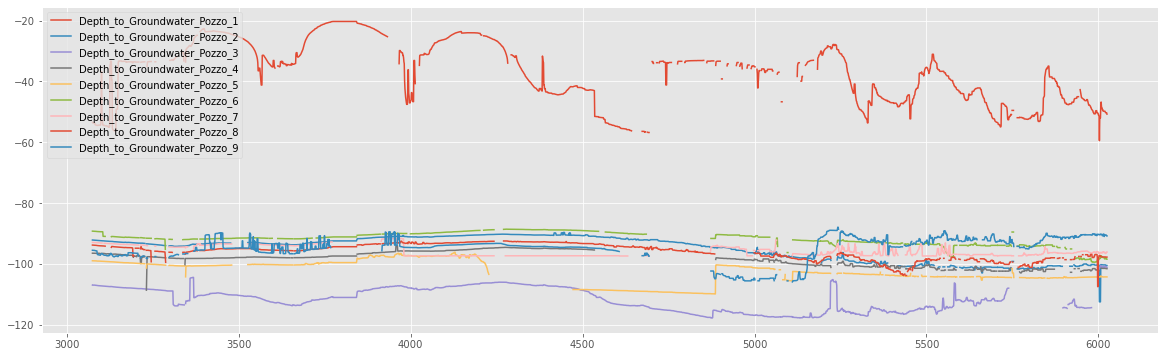

In [6]:
# target columns vis

plt.figure(figsize=(20, 6))
for i in range(1, 10):
    dfs['Aquifer_Doganella'][f"Depth_to_Groundwater_Pozzo_{i}"].plot()
plt.legend()
plt.show()

# Aquifer Auser

This waterbody consists of two subsystems, called `NORTH` and `SOUTH`, where the former partly influences the behavior of the latter. Indeed, the north subsystem is a water table (or unconfined) aquifer while the south subsystem is an artesian (or confined) groundwater.

The levels of the `NORTH` sector are represented by the values of the `SAL`, `PAG`, `CoS` and `DIEC` wells, while the levels of the `SOUTH` sector by the `LT2` well.

**Columns to predict**:
- `Depth_to_Groundwater_LT2`
- `Depth_to_Groundwater_SAL`
- `Depth_to_Groundwater_CoS`

In [7]:
dfs['Aquifer_Auser'].head()

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,Depth_to_Groundwater_LT2,Depth_to_Groundwater_SAL,Depth_to_Groundwater_PAG,Depth_to_Groundwater_CoS,Depth_to_Groundwater_DIEC,Temperature_Orentano,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
0,1998-05-03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan
1,1998-06-03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,10.05,nan,nan,nan,nan,nan,nan,nan
2,1998-07-03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,9.20,0.00,10.00,nan,nan,nan,nan,nan,nan,nan
3,1998-08-03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,11.40,0.00,13.85,nan,nan,nan,nan,nan,nan,nan
4,1998-09-03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,11.40,0.00,12.85,nan,nan,nan,nan,nan,nan,nan


In [8]:
dfs['Aquifer_Auser'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8154 entries, 0 to 8153
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date                                     8154 non-null   datetime64[ns]
 1   Rainfall_Gallicano                       5295 non-null   float64       
 2   Rainfall_Pontetetto                      5295 non-null   float64       
 3   Rainfall_Monte_Serra                     5289 non-null   float64       
 4   Rainfall_Orentano                        5295 non-null   float64       
 5   Rainfall_Borgo_a_Mozzano                 5295 non-null   float64       
 6   Rainfall_Piaggione                       4930 non-null   float64       
 7   Rainfall_Calavorno                       5295 non-null   float64       
 8   Rainfall_Croce_Arcana                    5295 non-null   float64       
 9   Rainfall_Tereglio_Coreglia_Antelminelli  

In [9]:
dfs['Aquifer_Auser'].describe()

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,Depth_to_Groundwater_LT2,Depth_to_Groundwater_SAL,Depth_to_Groundwater_PAG,Depth_to_Groundwater_CoS,Depth_to_Groundwater_DIEC,Temperature_Orentano,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
count,5295.00,5295.00,5289.00,5295.00,5295.00,4930.00,5295.00,5295.00,5295.00,5295.00,4802.00,4545.00,3807.00,4315.00,3270.00,8154.00,8154.00,8154.00,8154.00,5660.00,5660.00,5660.00,5660.00,5660.00,7241.00,6119.00
mean,4.95,3.50,3.92,3.15,4.58,3.95,4.58,2.85,4.18,5.92,-13.37,-5.65,-1.99,-6.32,-3.92,13.17,11.20,10.97,15.50,-137722.22,-16301.83,-11808.09,-2352.56,-1985.78,0.31,-0.21
std,14.37,9.98,10.82,8.75,12.77,10.89,12.46,9.24,11.14,16.28,1.04,0.64,0.67,1.38,0.68,8.28,6.90,8.71,7.14,873280.19,1490.10,1444.09,2854.18,2534.30,0.21,0.85
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-15.31,-7.00,-3.38,-9.57,-4.99,-4.65,-7.85,-2.85,-3.30,-7189406.53,-18601.92,-14438.30,-7757.26,-9497.77,0.00,-1.19
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-14.38,-6.04,-2.55,-7.47,-4.43,6.75,5.65,0.00,9.75,-11067.74,-17081.28,-12769.92,-5493.71,-4354.39,0.16,-1.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-13.04,-5.68,-1.97,-6.25,-4.06,13.35,11.00,10.88,15.40,-9855.42,-16450.56,-12078.72,0.00,0.00,0.26,-0.28
75%,2.00,1.00,1.60,1.00,2.00,1.40,2.00,1.40,2.00,3.00,-12.53,-5.30,-1.51,-5.09,-3.55,20.00,16.70,18.55,21.60,-7850.30,-15785.28,-11015.14,0.00,0.00,0.40,0.58
max,318.80,146.60,152.20,108.80,176.60,140.80,209.00,285.00,147.20,197.00,0.00,0.00,-0.09,0.00,-1.03,31.00,29.50,30.75,31.05,-4114.67,-7149.79,-5569.30,0.00,0.00,2.17,3.69


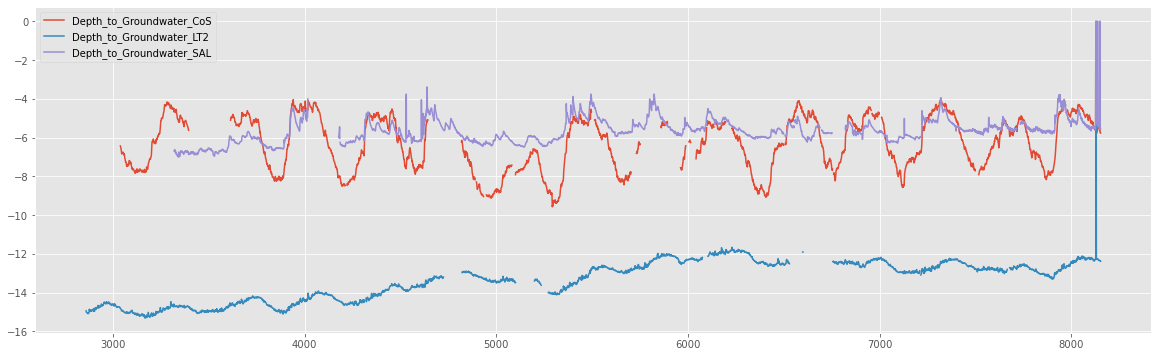

In [10]:
# target columns vis

plt.figure(figsize=(20, 6))
dfs['Aquifer_Auser']["Depth_to_Groundwater_CoS"].plot()
dfs['Aquifer_Auser']["Depth_to_Groundwater_LT2"].plot()
dfs['Aquifer_Auser']["Depth_to_Groundwater_SAL"].plot()
plt.legend()
plt.show()

# Water Spring Amiata

**Glossary**: a spring is a point at which water flows from an aquifer to the Earth's surface. It is a component of the hydrosphere.

The Amiata waterbody is composed of a volcanic aquifer not fed by rivers or lakes but fed by meteoric infiltration. This aquifer is accessed through Ermicciolo, Arbure, Bugnano and Galleria Alta water springs. The levels and volumes of the four sources are influenced by the parameters: rainfall, depth to groundwater, hydrometry, temperatures and drainage volumes.

**Columns to predict**:
- `Flow_Rate_Bugnano`
- `Flow_Rate_Arbure`
- `Flow_Rate_Ermicciolo`
- `Flow_Rate_Galleria_Alta`

In [11]:
dfs['Water_Spring_Amiata'].head()

,Date,Rainfall_Castel_del_Piano,Rainfall_Abbadia_S_Salvatore,Rainfall_S_Fiora,Rainfall_Laghetto_Verde,Rainfall_Vetta_Amiata,Depth_to_Groundwater_S_Fiora_8,Depth_to_Groundwater_S_Fiora_11bis,Depth_to_Groundwater_David_Lazzaretti,Temperature_Abbadia_S_Salvatore,Temperature_S_Fiora,Temperature_Laghetto_Verde,Flow_Rate_Bugnano,Flow_Rate_Arbure,Flow_Rate_Ermicciolo,Flow_Rate_Galleria_Alta
0,2000-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.15,nan,nan,nan,nan,nan
1,2000-02-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.55,nan,nan,nan,nan,nan
2,2000-03-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.70,nan,nan,nan,nan,nan
3,2000-04-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.00,nan,nan,nan,nan,nan
4,2000-05-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.60,nan,nan,nan,nan,nan


In [12]:
dfs['Water_Spring_Amiata'].describe()

,Rainfall_Castel_del_Piano,Rainfall_Abbadia_S_Salvatore,Rainfall_S_Fiora,Rainfall_Laghetto_Verde,Rainfall_Vetta_Amiata,Depth_to_Groundwater_S_Fiora_8,Depth_to_Groundwater_S_Fiora_11bis,Depth_to_Groundwater_David_Lazzaretti,Temperature_Abbadia_S_Salvatore,Temperature_S_Fiora,Temperature_Laghetto_Verde,Flow_Rate_Bugnano,Flow_Rate_Arbure,Flow_Rate_Ermicciolo,Flow_Rate_Galleria_Alta
count,6291.00,3586.00,2633.00,2865.00,2212.00,3569.00,3594.00,3242.00,3583.00,7487.00,3604.00,2008.00,2008.00,2008.00,2008.00
mean,2.62,3.78,4.10,4.33,2.87,-38.12,-51.64,-302.70,12.16,11.25,10.79,-0.26,-2.01,-4.51,-20.97
std,8.00,11.36,11.86,12.14,7.47,1.24,0.94,7.64,7.09,6.82,6.71,0.13,1.06,1.47,2.03
min,0.00,0.00,0.00,0.00,0.00,-40.79,-53.64,-314.71,-8.45,-8.95,-8.55,-0.39,-3.04,-6.47,-26.09
25%,0.00,0.00,0.00,0.00,0.00,-39.24,-52.44,-309.44,6.70,5.95,5.40,-0.35,-2.79,-5.42,-22.49
50%,0.00,0.00,0.00,0.00,0.00,-38.12,-51.65,-303.37,11.75,11.05,10.45,-0.32,-2.49,-4.86,-20.72
75%,0.60,1.40,1.80,1.80,1.40,-36.93,-50.76,-295.33,17.65,16.75,15.95,-0.22,-1.70,-3.87,-19.24
max,149.60,228.50,220.00,165.20,79.20,-36.38,-50.24,-290.58,30.15,28.20,28.00,0.00,0.00,0.00,-17.10


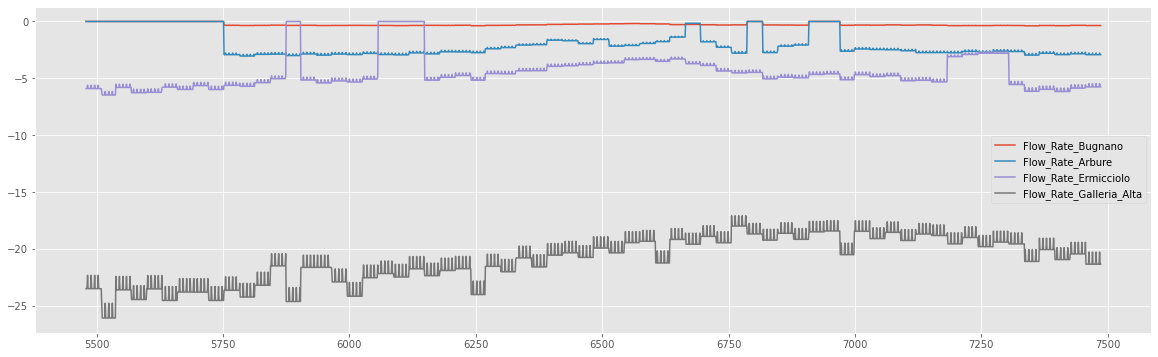

In [13]:
# target columns vis

plt.figure(figsize=(20, 6))
dfs['Water_Spring_Amiata']["Flow_Rate_Bugnano"].plot()
dfs['Water_Spring_Amiata']["Flow_Rate_Arbure"].plot()
dfs['Water_Spring_Amiata']["Flow_Rate_Ermicciolo"].plot()
dfs['Water_Spring_Amiata']["Flow_Rate_Galleria_Alta"].plot()
plt.legend()
plt.show()

# Lake Bilancino

Bilancino lake is an artificial lake located in the municipality of Barberino di Mugello (about 50 km from Florence). It is used to refill the Arno river during the summer months. Indeed, during the winter months, the lake is filled up and then, during the summer months, the water of the lake is poured into the Arno river.

**Type**: Lake
**Columns to predict**:
- `Lake_Level`
- `Flow_Rate`

In [14]:
dfs['Lake_Bilancino'].head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,2002-03-06,nan,nan,nan,nan,nan,nan,249.43,0.31
1,2002-04-06,nan,nan,nan,nan,nan,nan,249.43,0.31
2,2002-05-06,nan,nan,nan,nan,nan,nan,249.43,0.31
3,2002-06-06,nan,nan,nan,nan,nan,nan,249.43,0.31
4,2002-07-06,nan,nan,nan,nan,nan,nan,249.44,0.31


In [15]:
dfs['Lake_Bilancino'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  6603 non-null   datetime64[ns]
 1   Rainfall_S_Piero      6026 non-null   float64       
 2   Rainfall_Mangona      6026 non-null   float64       
 3   Rainfall_S_Agata      6026 non-null   float64       
 4   Rainfall_Cavallina    6026 non-null   float64       
 5   Rainfall_Le_Croci     6026 non-null   float64       
 6   Temperature_Le_Croci  6025 non-null   float64       
 7   Lake_Level            6603 non-null   float64       
 8   Flow_Rate             6582 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 515.9 KB


In [16]:
dfs['Lake_Bilancino'].describe()

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
count,6026.00,6026.00,6026.00,6026.00,6026.00,6025.00,6603.00,6582.00
mean,2.47,3.34,2.67,2.67,3.13,14.53,249.56,2.76
std,6.65,8.90,7.17,7.66,8.03,6.94,2.17,4.07
min,0.00,0.00,0.00,0.00,0.00,-5.35,243.53,0.31
25%,0.00,0.00,0.00,0.00,0.00,9.00,248.00,0.60
50%,0.00,0.00,0.00,0.00,0.00,14.50,250.20,1.50
75%,0.80,1.40,1.20,0.60,1.20,20.10,251.40,3.00
max,80.60,110.00,120.20,113.60,88.40,34.00,252.76,74.65


# Water Spring Madonna di Canneto

The Madonna di Canneto spring is situated at an altitude of 1010m above sea level in the Canneto valley. It does not consist of an aquifer and its source is supplied by the water catchment area of the river Melfa.

**Type**: `Water spring`

**Columns to predict**:
- `Flow_Rate_Madonna_di_Canneto`

In [17]:
dfs['Water_Spring_Madonna_di_Canneto'].head()

,Date,Rainfall_Settefrati,Temperature_Settefrati,Flow_Rate_Madonna_di_Canneto
0,2012-01-01,0.00,5.25,nan
1,2012-02-01,5.60,6.65,nan
2,2012-03-01,10.00,8.85,nan
3,2012-04-01,0.00,6.75,nan
4,2012-05-01,1.00,5.55,nan


In [18]:
dfs['Water_Spring_Madonna_di_Canneto'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3105 entries, 0 to 3104
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          3104 non-null   datetime64[ns]
 1   Rainfall_Settefrati           2557 non-null   float64       
 2   Temperature_Settefrati        2557 non-null   float64       
 3   Flow_Rate_Madonna_di_Canneto  1387 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 121.3 KB


In [19]:
dfs['Water_Spring_Madonna_di_Canneto'].describe()

,Rainfall_Settefrati,Temperature_Settefrati,Flow_Rate_Madonna_di_Canneto
count,2557.00,2557.00,1387.00
mean,4.25,13.56,263.16
std,10.24,6.96,32.07
min,0.00,-4.90,187.75
25%,0.00,7.60,224.66
50%,0.00,13.30,277.05
75%,3.60,19.05,290.17
max,140.80,31.10,300.16


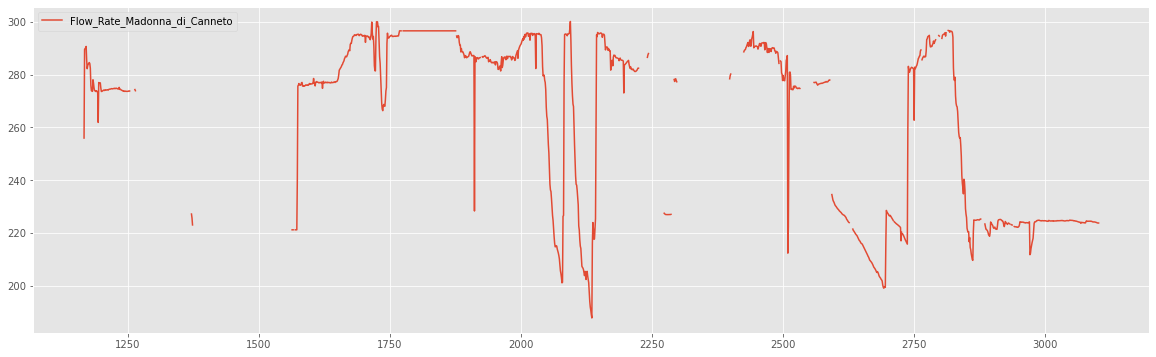

In [20]:
# target column vis

plt.figure(figsize=(20, 6))
dfs['Water_Spring_Madonna_di_Canneto']["Flow_Rate_Madonna_di_Canneto"].plot()
plt.legend()
plt.show()

# Aquifer Luco

The Luco wells field is fed by an underground aquifer. This aquifer not fed by rivers or lakes but by meteoric infiltration at the extremes of the impermeable sedimentary layers. Such aquifer is accessed through wells called Well 1, Well 3 and Well 4 and is influenced by the following parameters: rainfall, depth to groundwater, temperature and drainage volumes.

**Type**: Aquifer
**Columns to predict**:
- `Depth_to_Groundwater_Podere_Casetta`

In [21]:
dfs['Aquifer_Luco'].head()

,Date,Rainfall_Simignano,Rainfall_Siena_Poggio_al_Vento,Rainfall_Mensano,Rainfall_Montalcinello,Rainfall_Monticiano_la_Pineta,Rainfall_Sovicille,Rainfall_Ponte_Orgia,Rainfall_Scorgiano,Rainfall_Pentolina,Rainfall_Monteroni_Arbia_Biena,Depth_to_Groundwater_Podere_Casetta,Depth_to_Groundwater_Pozzo_1,Depth_to_Groundwater_Pozzo_3,Depth_to_Groundwater_Pozzo_4,Temperature_Siena_Poggio_al_Vento,Temperature_Mensano,Temperature_Pentolina,Temperature_Monteroni_Arbia_Biena,Volume_Pozzo_1,Volume_Pozzo_3,Volume_Pozzo_4
0,2000-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,5.50,0.80,nan,nan,nan
1,2000-02-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,6.20,3.25,nan,nan,nan
2,2000-03-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,7.25,0.95,nan,nan,nan
3,2000-04-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,7.00,4.20,nan,nan,nan
4,2000-05-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,7.90,6.55,nan,nan,nan


In [22]:
dfs['Aquifer_Luco'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7487 entries, 0 to 7486
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Date                                 7487 non-null   datetime64[ns]
 1   Rainfall_Simignano                   6822 non-null   float64       
 2   Rainfall_Siena_Poggio_al_Vento       951 non-null    float64       
 3   Rainfall_Mensano                     1722 non-null   float64       
 4   Rainfall_Montalcinello               6525 non-null   float64       
 5   Rainfall_Monticiano_la_Pineta        2205 non-null   float64       
 6   Rainfall_Sovicille                   6657 non-null   float64       
 7   Rainfall_Ponte_Orgia                 1260 non-null   float64       
 8   Rainfall_Scorgiano                   3036 non-null   float64       
 9   Rainfall_Pentolina                   2116 non-null   float64       
 10  Rainfall_Mon

In [23]:
dfs['Aquifer_Luco'].describe()

,Rainfall_Simignano,Rainfall_Siena_Poggio_al_Vento,Rainfall_Mensano,Rainfall_Montalcinello,Rainfall_Monticiano_la_Pineta,Rainfall_Sovicille,Rainfall_Ponte_Orgia,Rainfall_Scorgiano,Rainfall_Pentolina,Rainfall_Monteroni_Arbia_Biena,Depth_to_Groundwater_Podere_Casetta,Depth_to_Groundwater_Pozzo_1,Depth_to_Groundwater_Pozzo_3,Depth_to_Groundwater_Pozzo_4,Temperature_Siena_Poggio_al_Vento,Temperature_Mensano,Temperature_Pentolina,Temperature_Monteroni_Arbia_Biena,Volume_Pozzo_1,Volume_Pozzo_3,Volume_Pozzo_4
count,6822.00,951.00,1722.00,6525.00,2205.00,6657.00,1260.00,3036.00,2116.00,3104.00,3346.00,1012.00,920.00,969.00,7487.00,7487.00,7487.00,7487.00,2008.00,2008.00,2008.00
mean,2.52,2.27,2.56,2.48,3.11,2.28,2.37,3.22,8.73,2.39,-7.08,-11.10,-9.89,-13.10,1.90,3.34,13.42,13.59,-160.68,-147.77,-135.21
std,7.09,6.04,10.28,7.49,9.50,7.05,6.81,21.31,52.15,7.60,1.16,0.84,0.67,2.57,5.60,6.92,7.25,7.20,51.22,55.64,56.82
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-9.60,-12.60,-11.90,-19.00,-3.55,-5.25,-4.80,-3.90,-295.38,-261.85,-237.34
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-7.90,-11.60,-10.30,-13.00,0.00,0.00,7.95,7.95,-198.76,-189.34,-175.18
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-7.30,-11.20,-9.80,-12.70,0.00,0.00,13.20,13.70,-163.55,-148.87,-145.85
75%,0.60,1.20,0.60,0.60,0.80,0.40,0.60,0.80,1.20,0.60,-6.30,-10.60,-9.40,-11.40,0.00,0.00,19.35,19.65,-119.62,-110.47,-96.85
max,87.80,79.20,313.00,134.60,171.00,194.20,90.00,794.20,620.80,137.60,-4.80,-2.80,-8.20,0.00,31.80,31.85,31.30,29.45,-55.43,0.00,-0.05


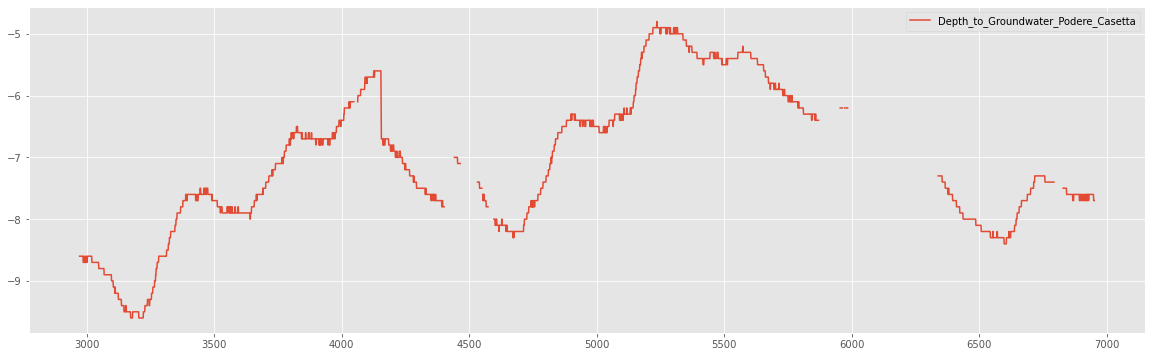

In [24]:
# target column vis

plt.figure(figsize=(20, 6))
dfs['Aquifer_Luco']["Depth_to_Groundwater_Podere_Casetta"].plot()
plt.legend()
plt.show()

# Aquifer Petrignano

The wells field of the alluvial plain between Ospedalicchio di Bastia Umbra and Petrignano is fed by three underground aquifers separated by low permeability septa. The aquifer can be considered a water table groundwater and is also fed by the Chiascio river. The groundwater levels are influenced by the following parameters: rainfall, depth to groundwater, temperatures and drainage volumes, level of the Chiascio river.

**Type**: Aquifer
**Columns to predict**:
- `Depth_to_Groundwater_P24`
- `Depth_to_Groundwater_P25`

In [25]:
dfs['Aquifer_Petrignano'].head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,2006-03-14,nan,-22.48,-22.18,nan,nan,nan,nan
1,2006-03-15,nan,-22.38,-22.14,nan,nan,nan,nan
2,2006-03-16,nan,-22.25,-22.04,nan,nan,nan,nan
3,2006-03-17,nan,-22.38,-22.04,nan,nan,nan,nan
4,2006-03-18,nan,-22.60,-22.04,nan,nan,nan,nan


In [26]:
dfs['Aquifer_Petrignano'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date                                  5223 non-null   datetime64[ns]
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64       
 2   Depth_to_Groundwater_P24              5168 non-null   float64       
 3   Depth_to_Groundwater_P25              5184 non-null   float64       
 4   Temperature_Bastia_Umbra              4199 non-null   float64       
 5   Temperature_Petrignano                4199 non-null   float64       
 6   Volume_C10_Petrignano                 5025 non-null   float64       
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 367.2 KB


In [27]:
dfs['Aquifer_Petrignano'].describe()

,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
count,4199.00,5168.00,5184.00,4199.00,4199.00,5025.00,4199.00
mean,1.56,-26.26,-25.69,15.03,13.74,-29043.30,2.37
std,5.22,3.32,3.21,7.79,7.70,4751.86,0.59
min,0.00,-34.47,-33.71,-3.70,-4.20,-45544.90,0.00
25%,0.00,-28.25,-27.62,8.80,7.70,-31678.56,2.10
50%,0.00,-25.99,-25.54,14.70,13.50,-28689.12,2.40
75%,0.10,-23.82,-23.43,21.40,20.00,-26218.08,2.70
max,67.30,-19.66,-19.10,33.00,31.10,0.00,4.10


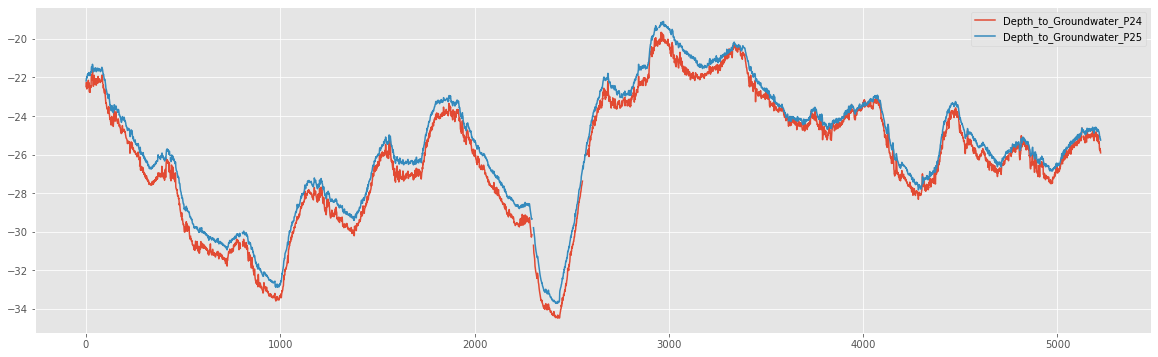

In [28]:
# target columns vis

plt.figure(figsize=(20, 6))
dfs['Aquifer_Petrignano']["Depth_to_Groundwater_P24"].plot()
dfs['Aquifer_Petrignano']["Depth_to_Groundwater_P25"].plot()
plt.legend()
plt.show()

In [29]:
# sns.pairplot(dfs['Aquifer_Petrignano'])
# plt.show()

# Water Spring Lupa

This water spring is located in the Rosciano Valley, on the left side of the Nera river. The waters emerge at an altitude of about 375 meters above sea level through a long draining tunnel that crosses, in its final section, lithotypes and essentially calcareous rocks. It provides drinking water to the city of Terni and the towns around it.

**Type**: Water spring
**Columns to predict**:
- `Flow_Rate_Lupa`

In [30]:
dfs['Water_Spring_Lupa'].head()

,Date,Rainfall_Terni,Flow_Rate_Lupa
0,2009-01-01,2.80,nan
1,2009-02-01,2.80,nan
2,2009-03-01,2.80,nan
3,2009-04-01,2.80,nan
4,2009-05-01,2.80,nan


In [31]:
dfs['Water_Spring_Lupa'].describe()

,Rainfall_Terni,Flow_Rate_Lupa
count,4199.00,3817.00
mean,2.47,-97.71
std,2.04,15.03
min,0.00,-182.31
25%,1.40,-105.76
50%,2.14,-96.59
75%,3.17,-87.22
max,76.00,0.00


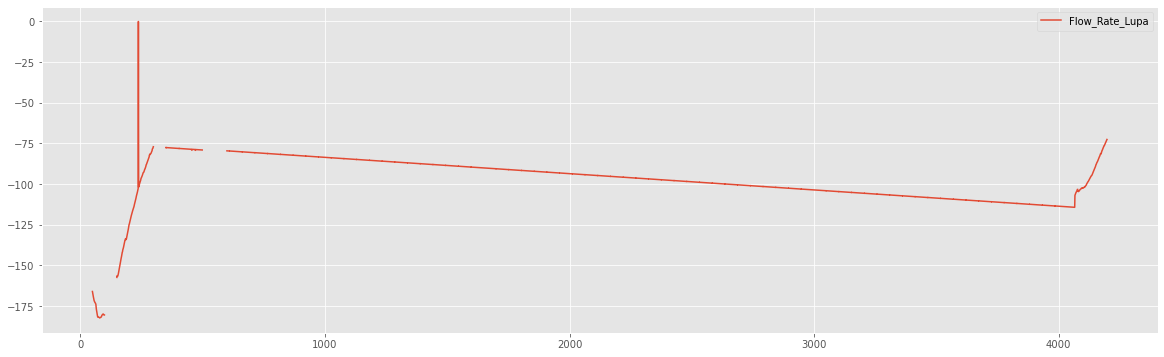

In [32]:
# target column vis

plt.figure(figsize=(20, 6))
dfs['Water_Spring_Lupa']["Flow_Rate_Lupa"].plot()
plt.legend()
plt.show()

In [33]:
# sns.pairplot(dfs['Water_Spring_Lupa'])
# plt.show()

# River Arno

Arno is the second largest river in peninsular Italy and the main waterway in Tuscany and it has a relatively torrential regime, due to the nature of the surrounding soils (marl and impermeable clays). Arno results to be the main source of water supply of the metropolitan area of Florence-Prato-Pistoia. The availability of water for this waterbody is evaluated by checking the hydrometric level of the river at the section of Nave di Rosano.

**Type**: River
**Columns to predict**:
- `Hydrometry_Nave_di_Rosano`

In [34]:
dfs['River_Arno'].head()

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
0,1998-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.82
1,1998-02-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.94
2,1998-03-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.11
3,1998-04-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.84
4,1998-05-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.88


In [35]:
dfs['River_Arno'].describe()

,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
count,6026.00,6026.00,6026.00,6026.00,6026.00,4283.00,1283.00,1283.00,4568.00,1647.00,1283.00,1283.00,2378.00,1283.00,6192.00,8169.00
mean,3.13,2.67,2.67,3.34,2.47,3.42,2.54,3.42,2.34,2.06,2.43,2.10,2.64,3.83,16.61,1.47
std,8.03,7.66,7.17,8.90,6.65,9.43,6.50,8.94,6.35,6.12,7.23,6.38,7.16,9.59,7.46,0.62
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.70,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.65,1.10
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16.35,1.30
75%,1.20,0.60,1.20,1.40,0.80,1.20,1.00,2.20,0.80,0.60,0.70,0.40,1.20,2.40,22.70,1.69
max,88.40,113.60,120.20,110.00,80.60,126.00,63.00,114.40,102.20,75.00,123.20,95.60,77.40,103.60,34.90,6.75


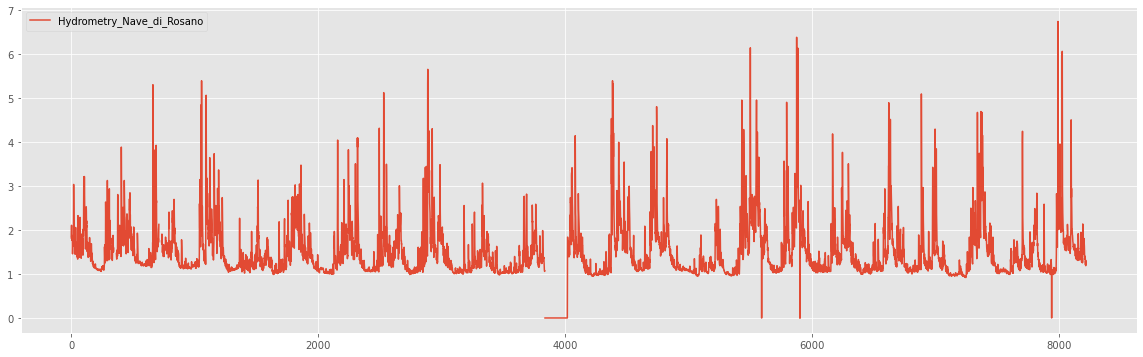

In [36]:
# target column vis

plt.figure(figsize=(20, 6))
dfs['River_Arno']["Hydrometry_Nave_di_Rosano"].plot()
plt.legend()
plt.show()

Note that the zero value is implausible here, but it does occur from time to time. This is not the only example of this data behavior.

In [37]:
sum(dfs['River_Arno']["Hydrometry_Nave_di_Rosano"] == 0)

187

# Additional information: italian locations observed in datasets

- Borgo-a-Mozzano
- Calavorno
- Croce Arcana
- Fabbriche di Vallico
- Gallicano
- Mensano
- Montalcinello
- Monticiano la Pineta
- Monteporzio
- Monteroni Arbia Biena
- Monte Serra
- Orentano
- Pontetetto
- Pentolina
- Petrignano
- Piaggione
- Podere Casetta
- Ponte Orgia
- Siena Poggio al Vento
- Simignano
- Scorgiano
- Sovicille
- Tereglio Coreglia Antelminelli
- Umbra
- Velletri

# Preprocessing invalid zero values

A lot of data columns contain missing values or invalid zeros. For subsequent correct predictions, let's process these items. Zero values will be replaced by NA. Next, we will replace all the gaps with the values predicted using the rest of the data. Based on preliminary analysis of the data, the following columns were identified with unexpected  single or consecutive zero values.

In [38]:
# Zero values where they shouldn't be
invalid_zeros = {"Aquifer_Auser": ["Depth_to_Groundwater_LT2",
                                        "Depth_to_Groundwater_SAL",
                                        "Depth_to_Groundwater_CoS"],
                     "Aquifer_Petrignano": ["Volume_C10_Petrignano"],
                     "River_Arno": ["Hydrometry_Nave_di_Rosano"]}


# chains of repeating zero values where zero values can be, but cannot be repeated this way
invalid_zeros_chains = {"Aquifer_Auser": ["Temperature_Orentano",
                                         "Temperature_Ponte_a_Moriano",
                                         "Volume_CSA",
                                         "Volume_CSAL"],
                      "Water_Spring_Amiata": ["Flow_Rate_Bugnano"],
                      "Aquifer_Luco": ["Temperature_Siena_Poggio_al_Vento",
                                       "Temperature_Mensano",
                                       "Temperature_Pentolina"],
                      "Aquifer_Petrignano": ["Temperature_Petrignano",
                                             "Hydrometry_Fiume_Chiascio_Petrignano"]}

In [39]:
from itertools import groupby

def remove_repeated_zeros(seq):
    result = []
    for (key, group) in groupby(seq):
        g = list(group)
        if (len(g) > 1) and (key == 0):
            result += [np.nan]*len(g)
        else:
            result.append(key)
    return pd.Series(result)

Let's apply the techniques of removing individual zeros and sequences of zeros to the entire dataset.

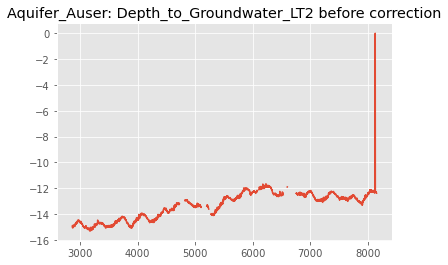

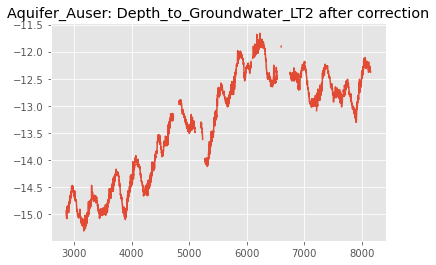

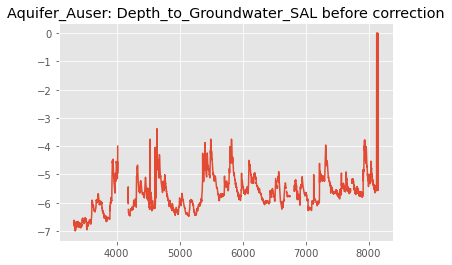

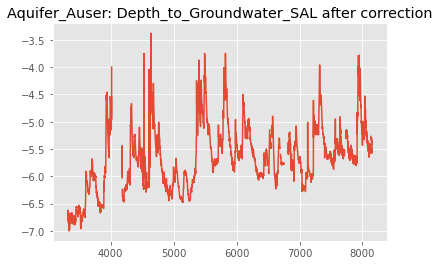

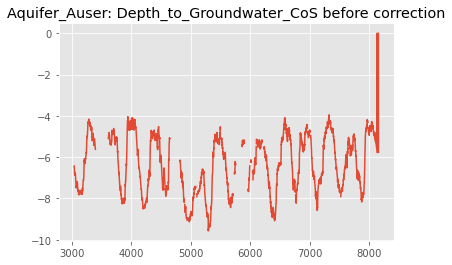

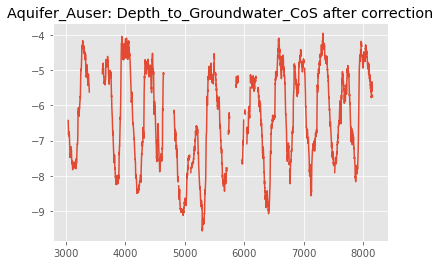

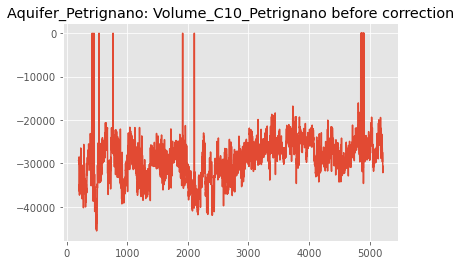

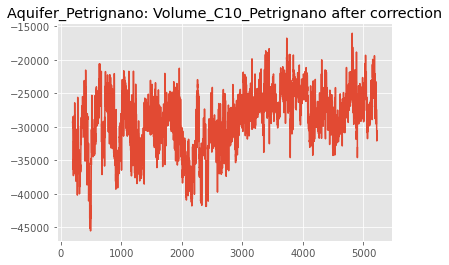

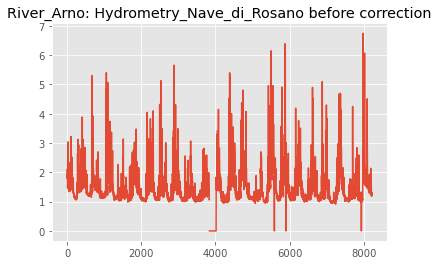

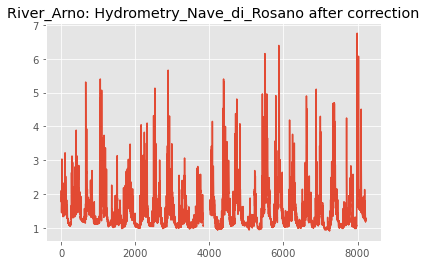

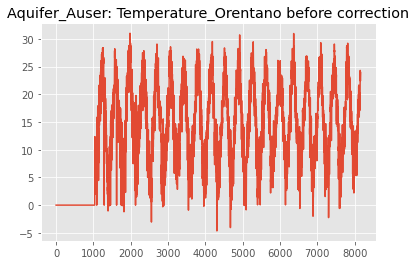

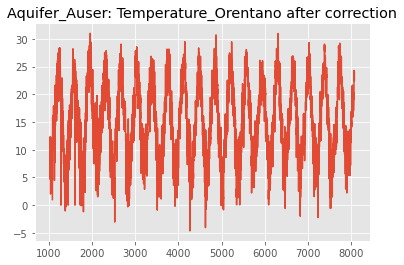

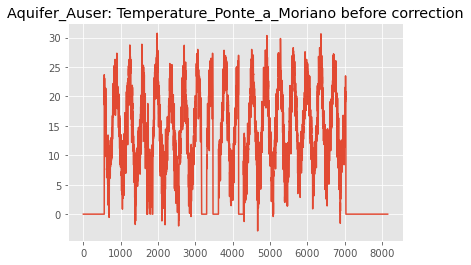

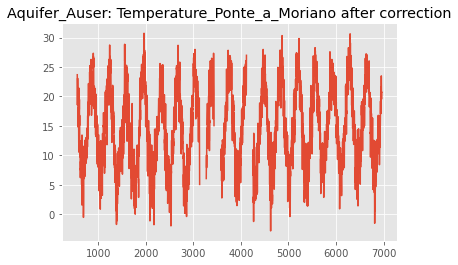

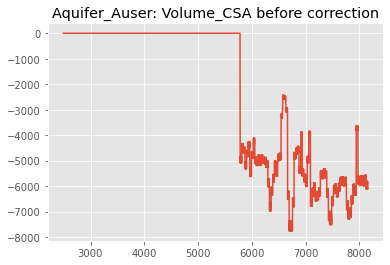

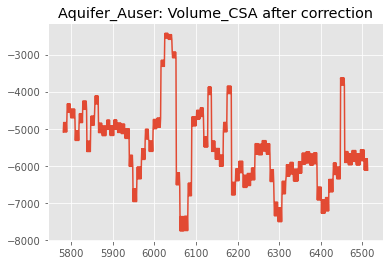

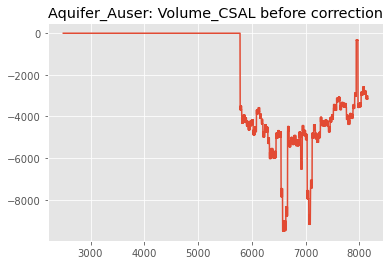

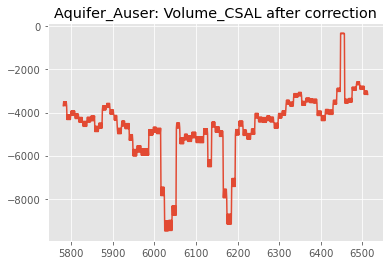

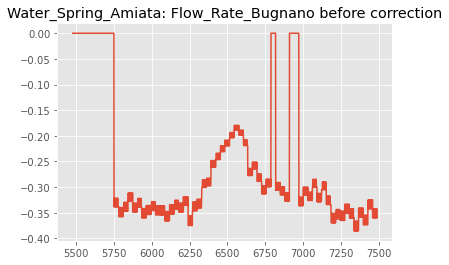

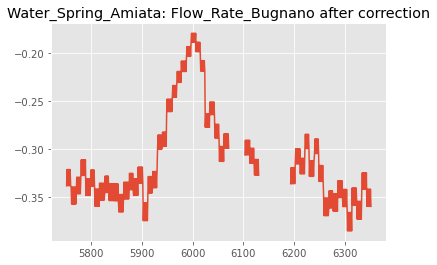

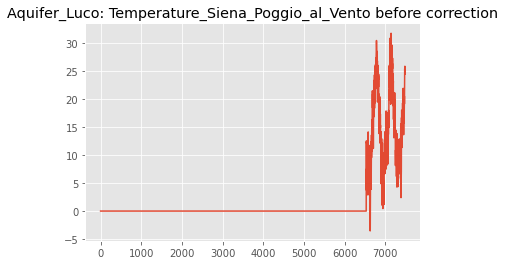

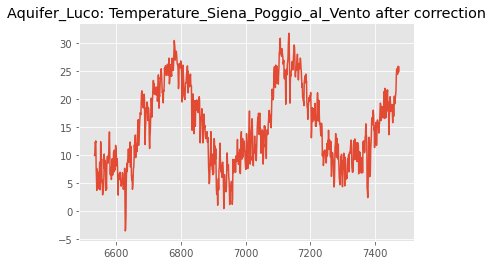

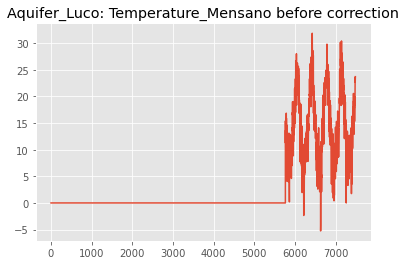

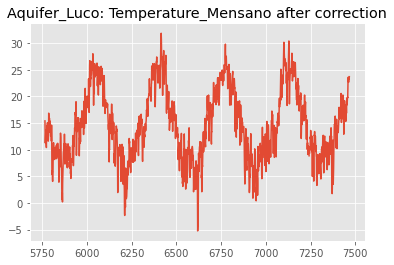

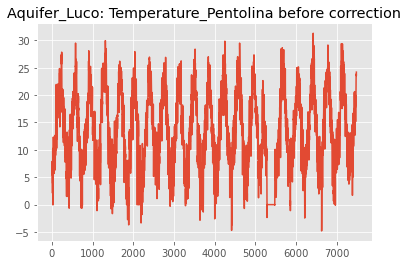

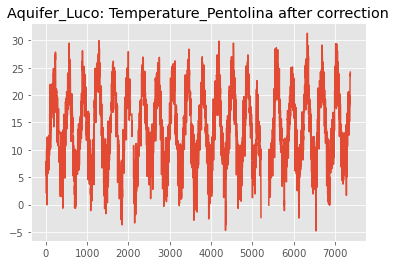

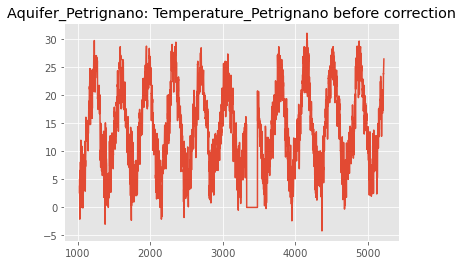

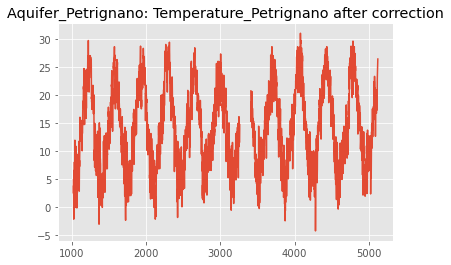

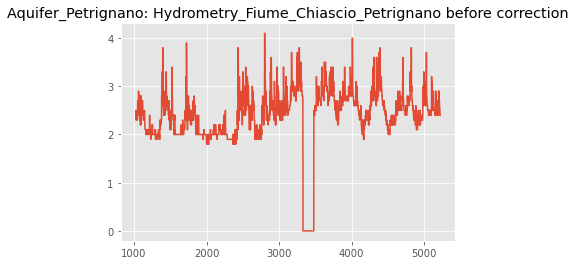

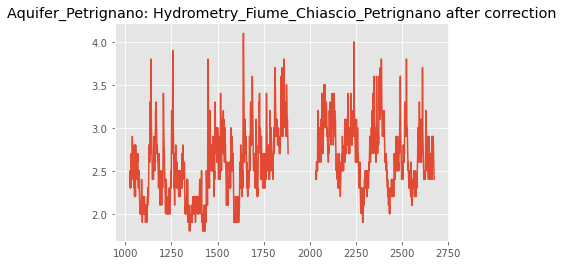

In [40]:
for key in invalid_zeros:
    for col in invalid_zeros[key]:
        plt.title(f"{key}: {col} before correction")
        dfs[key][col].plot()
        plt.show()
        plt.title(f"{key}: {col} after correction")
        dfs[key][col].replace(0, np.nan, inplace=True)
        dfs[key][col].plot()
        plt.show()
        
for key in invalid_zeros_chains:
    for col in invalid_zeros_chains[key]:
        plt.title(f"{key}: {col} before correction")
        dfs[key][col].plot()
        plt.show()
        plt.title(f"{key}: {col} after correction")
        dfs[key][col] = remove_repeated_zeros(dfs[key][col])
        dfs[key][col].plot()
        plt.show()

Let's see distrbution of na-values:

Aquifer_Doganella


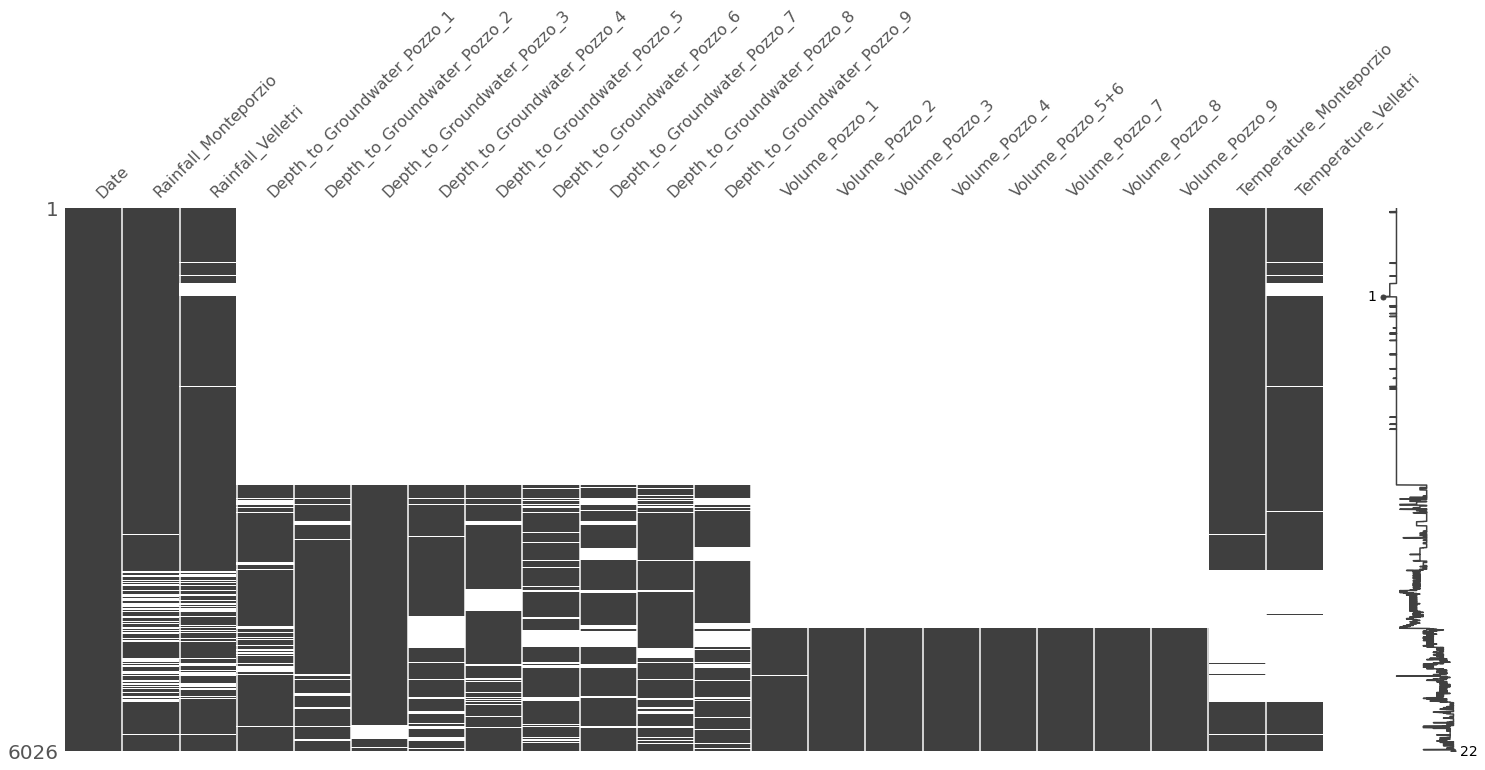

Aquifer_Auser


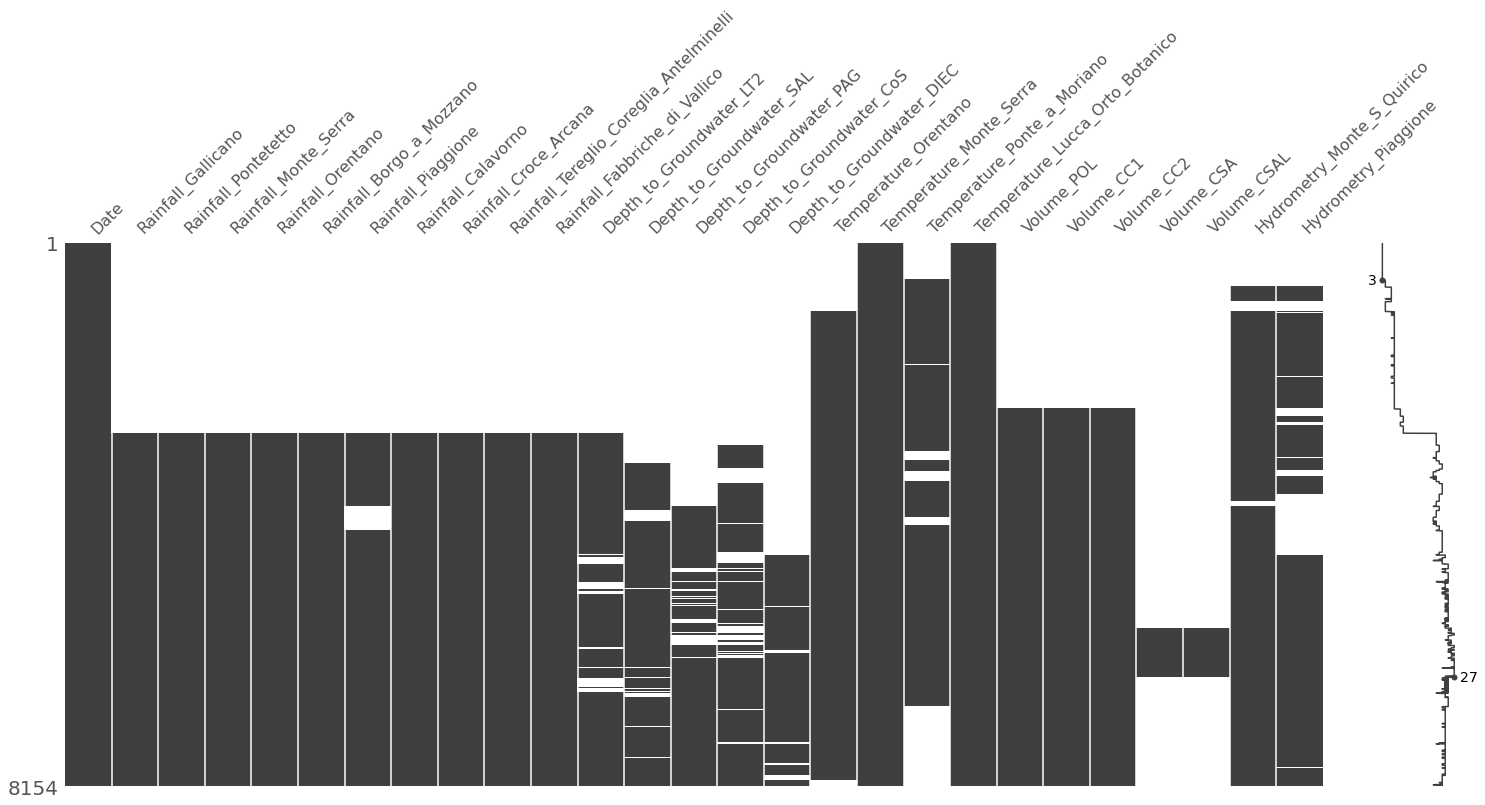

Water_Spring_Amiata


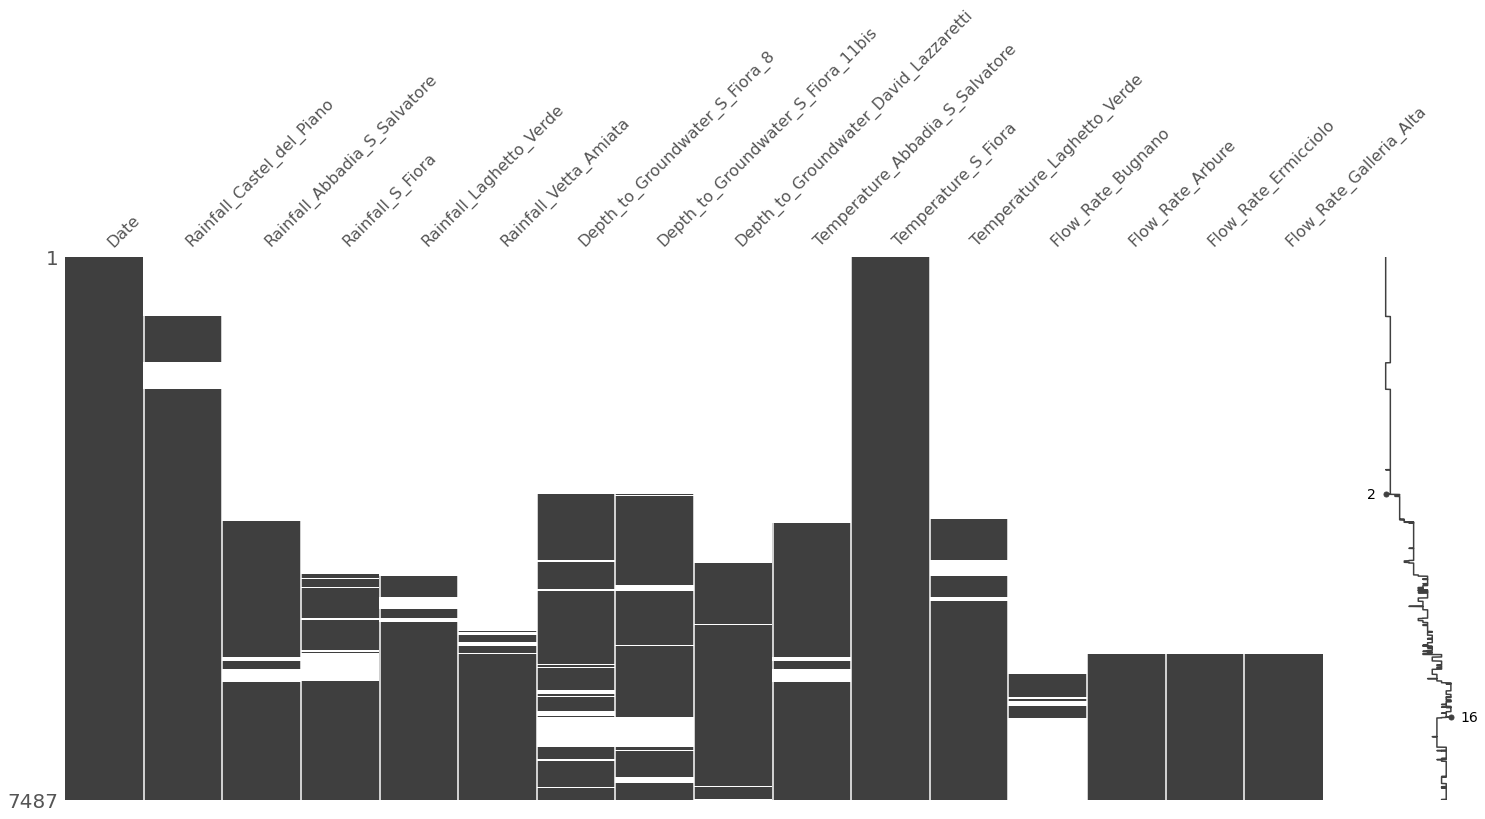

Lake_Bilancino


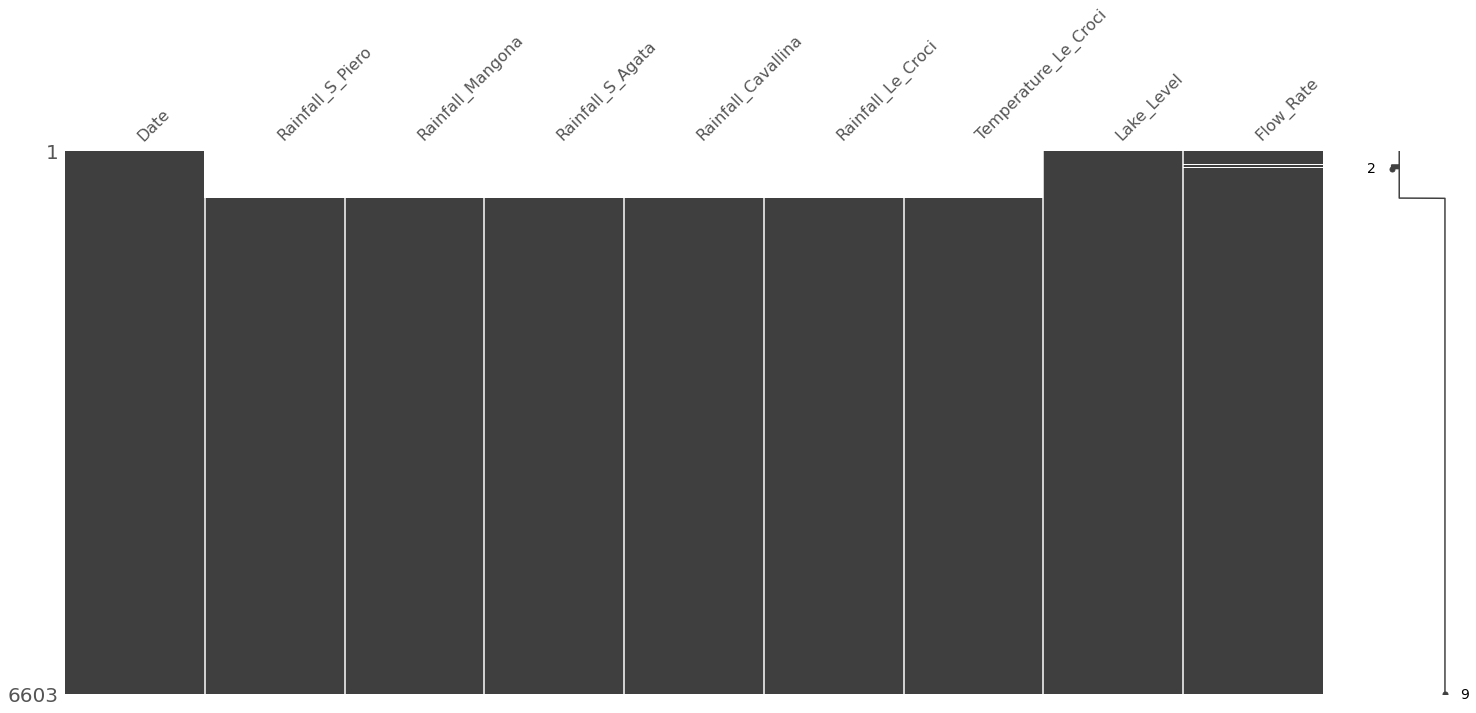

Water_Spring_Madonna_di_Canneto


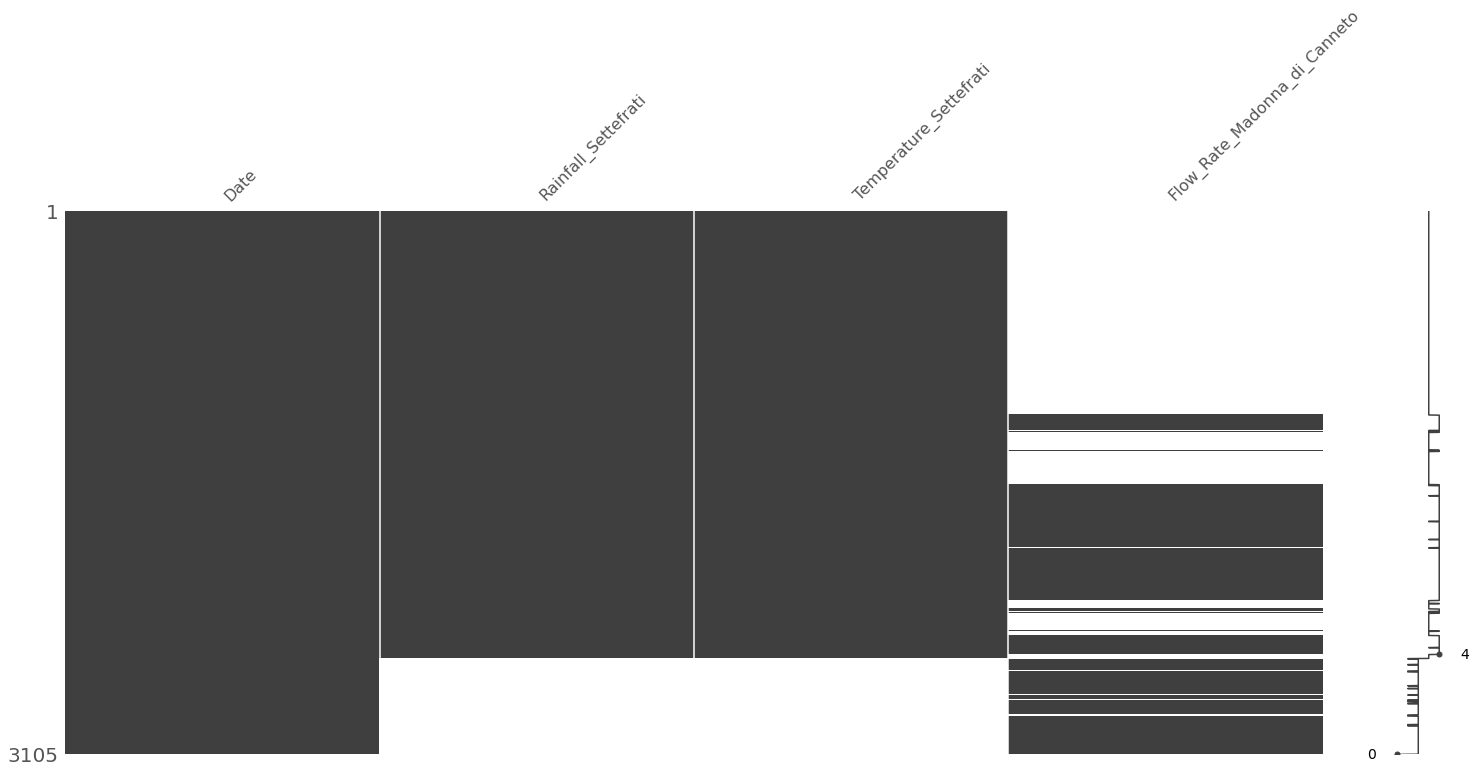

Aquifer_Luco


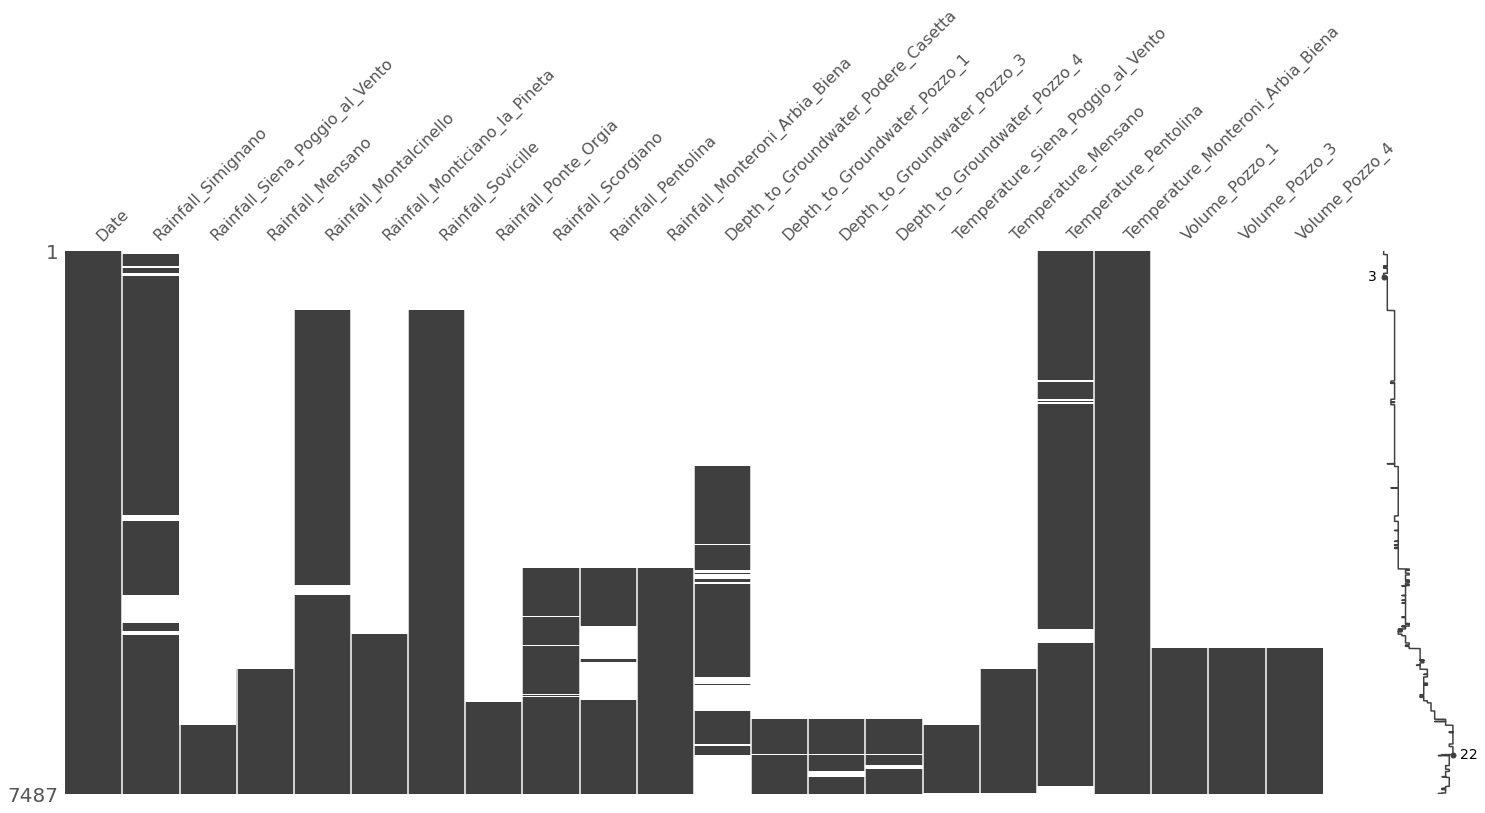

Aquifer_Petrignano


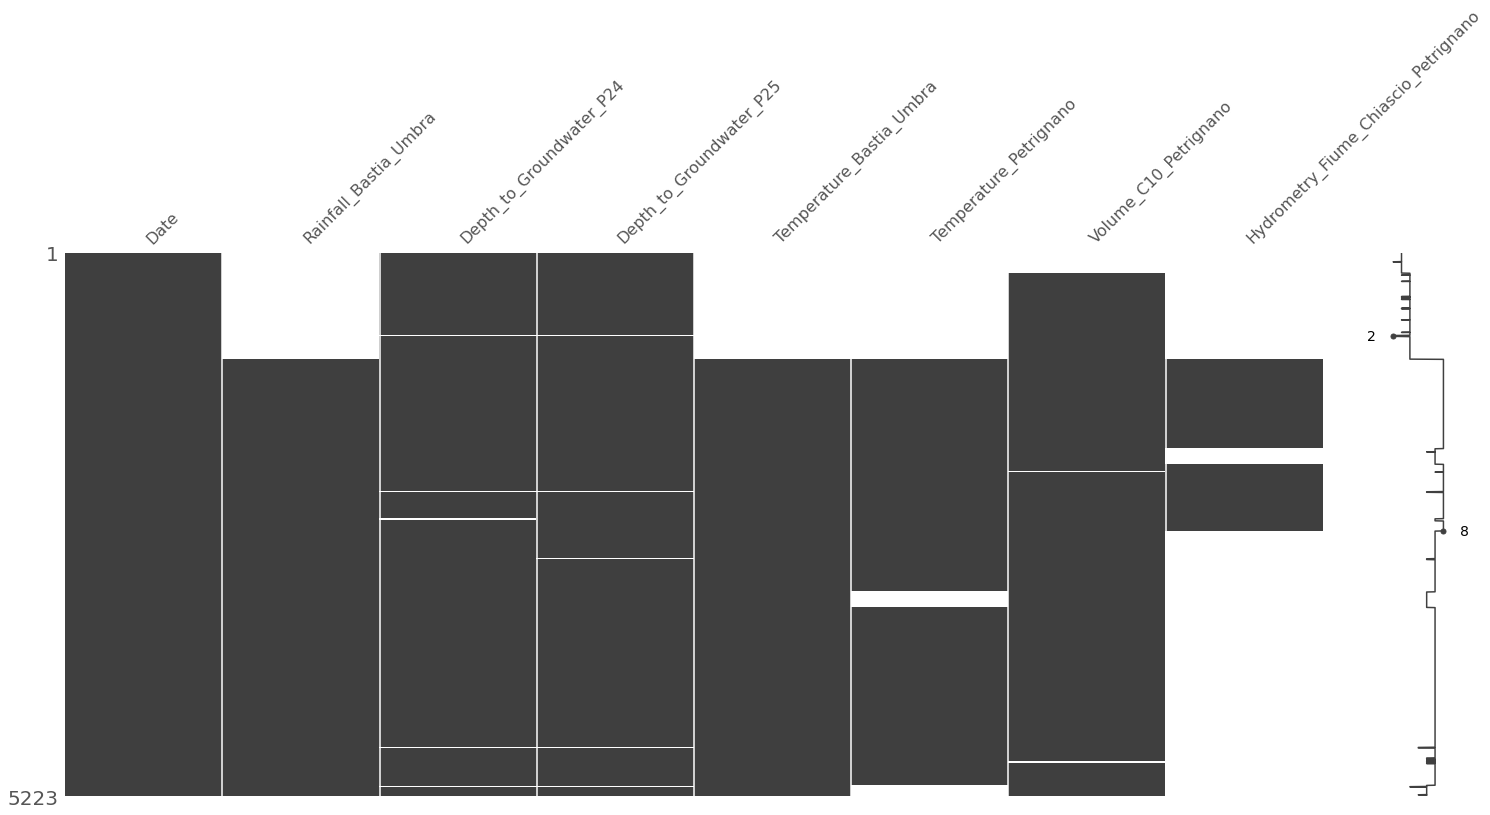

Water_Spring_Lupa


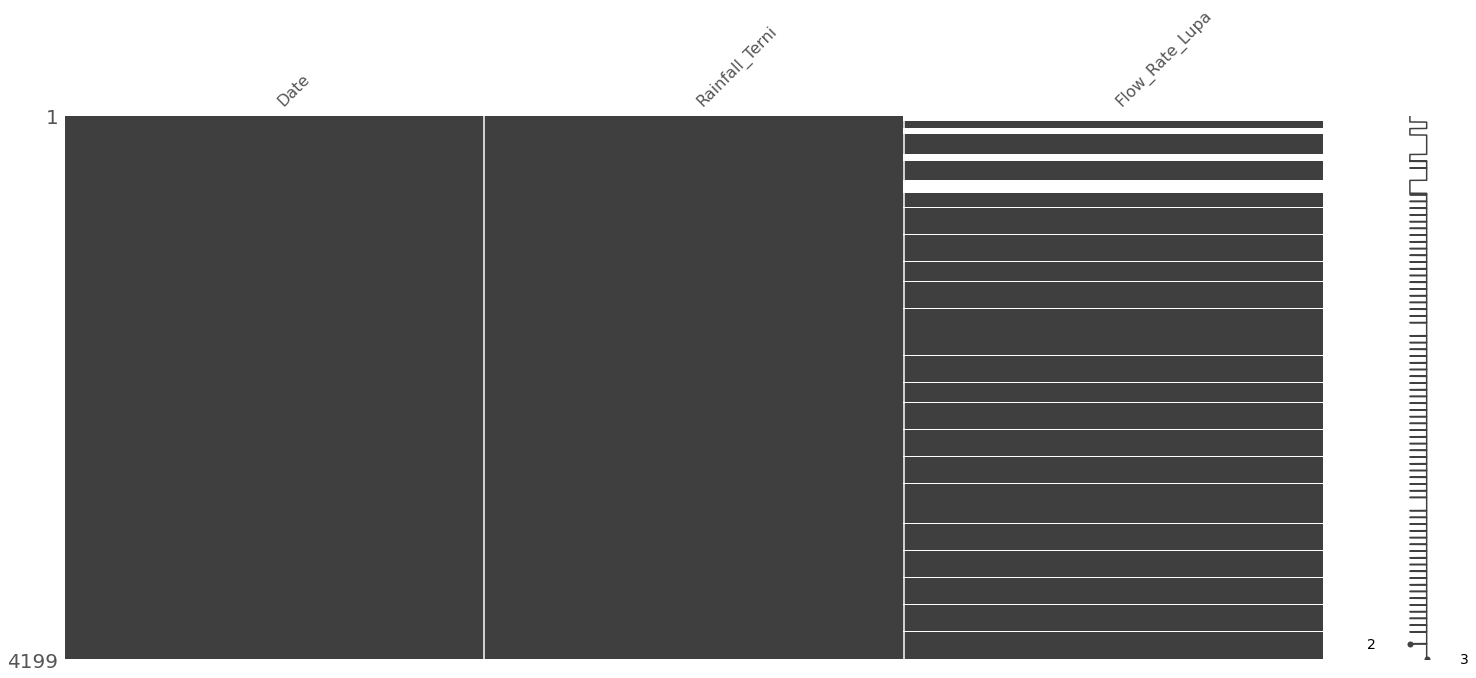

River_Arno


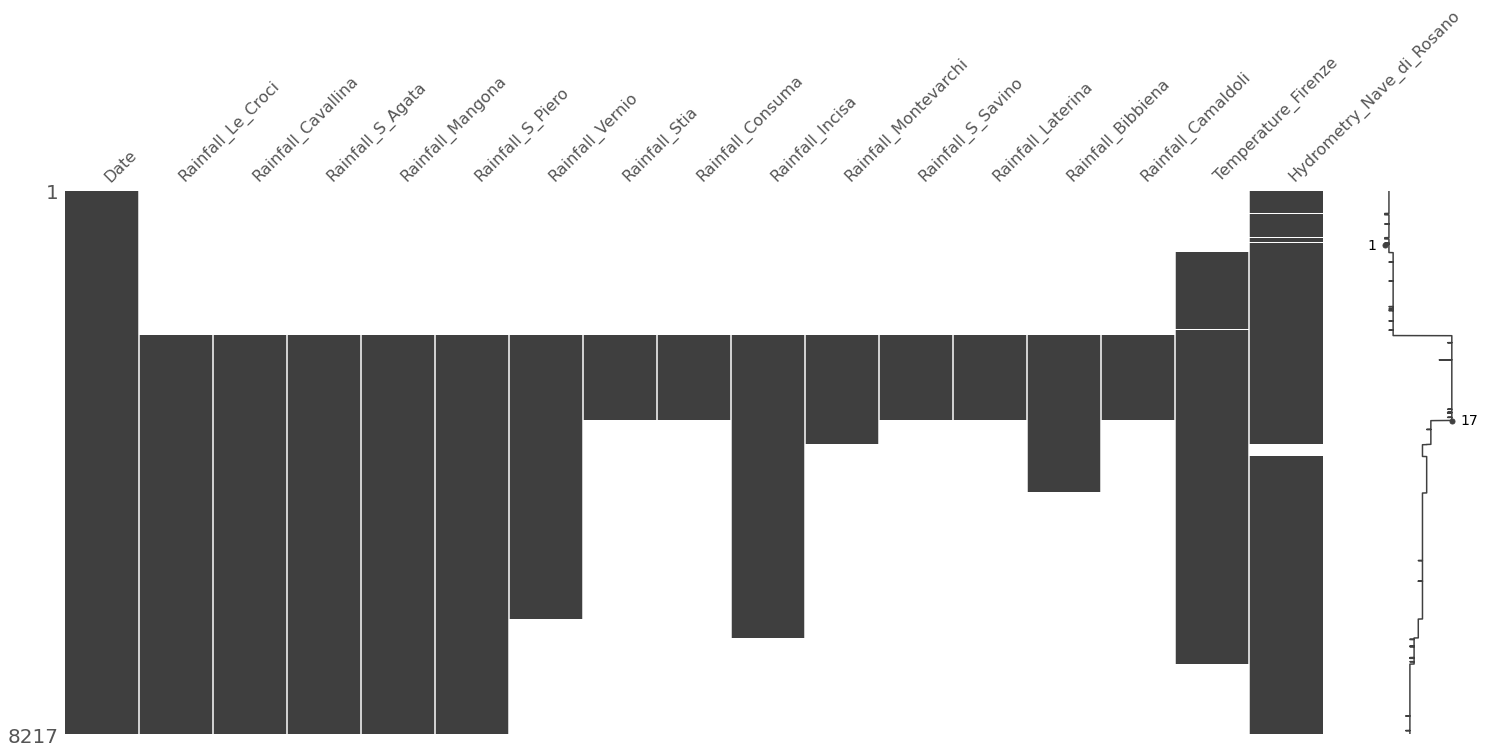

In [41]:
# !pip install missingno  # for missing values
import missingno as msno

for key in dfs:
    print(key)
    msno.matrix(dfs[key])
    plt.show()

For convenience of grouping let's add dates in the form of days, weeks and months of a separate year.

In [42]:
for key in dfs:
    dfs[key]['year'] = dfs[key]['Date'].dt.year
    dfs[key]['y_month'] = dfs[key]['Date'].dt.month
    dfs[key]['y_week'] = dfs[key]['Date'].dt.week
    dfs[key]['y_day'] = dfs[key]['Date'].dt.dayofyear

To be continued...

# Sources

## EDA Sources
- [isaenkov](https://www.kaggle.com/isaienkov/acea-smart-water-analytics-data-understanding)
- [thanish](https://www.kaggle.com/thanish/starters-eda)
- [salmanhiro](https://www.kaggle.com/salmanhiro/eda-and-data-storytelling)
- [ekrembayar](https://www.kaggle.com/ekrembayar/quick-eda-reporting-data-understanding)
- [pjoshi15](https://www.kaggle.com/pjoshi15/understanding-the-dataset)